# Clustering de documents

## Imports

In [82]:
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [83]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/chloe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [84]:
data_path = "data/"

## Charger tous les  fichiers de la décennie et en créer une liste de textes

In [85]:
!rm data_path"_README.txt"
files = [f for f in sorted(os.listdir(data_path)) if not f.startswith('.') and f.endswith('.txt')]
len(files)


rm: impossible de supprimer 'data_path_README.txt': Aucun fichier ou dossier de ce type


1013

In [86]:
# Exemple de fichiers
files[:5]

['KB_JB421_1900-04-21_01-00003.txt',
 'KB_JB421_1905-11-26_01-00001.txt',
 'KB_JB421_1906-01-20_01-00001.txt',
 'KB_JB421_1907-06-02_01-00003.txt',
 'KB_JB421_1908-03-19_01-00004.txt']

In [87]:
texts = []
for f in files:
    try:
        with open(os.path.join(data_path, f), "r", encoding="utf-8") as file:
            texts.append(file.read())
    except FileNotFoundError:
        print(f"Erreur : Le fichier {f} n'a pas été trouvé dans le chemin {data_path}")

In [88]:
# Exemple de textes
texts[0][:400]

"omatose Reconstituant par excellence. Recommandé dans Anémie, Chlorose, Habilité, AmaisrlssemeD-, Inappétence, enfants adultes, vieillards Dem. nharm. Dépôt gén p' la Belgique : Fr. BAYER et O, 79, rue de Brabant, Bruxelles-Nord. 3S0 Choses et autres. Voulez-vous permettre à un vieux parisien de vous donner quelques conseils pratiques, qui ne vous seront pas inutiles à ceux qui iront visiter l'Exp"

## Vectoriser les documents à l'aide de TF-IDF

In [89]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

### Instancier le modèle TF-IDF avec ses arguments

In [90]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

### Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

In [91]:
tfidf_vectors = vectorizer.fit_transform(texts)

/home/chloe/STIC/tac/tac_venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Détail de la matrice
tfidf_vectors

<1012x4016 sparse matrix of type '<class 'numpy.float64'>'
	with 826005 stored elements in Compressed Sparse Row format>

### Imprimer le vecteur tf-IDF du premier document

In [ ]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

lorand       0.200370
officiers    0.149420
vivre        0.144972
dieu         0.136389
fils         0.134308
               ...   
esl          0.000000
esp          0.000000
espagne      0.000000
espagnol     0.000000
♦            0.000000
Length: 4016, dtype: float64

## Comprendre les vecteurs et leurs "distances"

In [ ]:
cosine([1, 2, 3], [1, 2, 3])

0

In [ ]:
cosine([1, 2, 3], [1, 2, 2])

0.02004211298777725

In [ ]:
cosine([1, 2, 3], [2, 2, 2])

0.07417990022744858

### Tests sur nos documents

In [ ]:
tfidf_array = tfidf_vectors.toarray()

In [ ]:
# Vecteur du document 0
tfidf_array[0]

array([0.        , 0.04987051, 0.        , ..., 0.        , 0.        ,
       0.        ])

In [ ]:
# Vecteur du document 1
tfidf_array[1]

array([0.        , 0.07225508, 0.        , ..., 0.        , 0.        ,
       0.        ])

In [ ]:
cosine(tfidf_array[0], tfidf_array[1])

0.9347875457655868

## Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

Pour en savoir plus sur le KMeans clustering :
- https://medium.com/dataseries/k-means-clustering-explained-visually-in-5-minutes-b900cc69d175

### Définir un nombre de clusters

In [ ]:
N_CLUSTERS = 3

### Instancier le modèle K-Means et ses arguments

In [ ]:
km_model = KMeans(n_clusters=N_CLUSTERS)

### Appliquer le clustering à l'aide de la fonction `fit_predict`

In [ ]:
clusters = km_model.fit_predict(tfidf_vectors)

/home/chloe/STIC/tac/tac_venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [ ]:
# Création de trois listes pour les clusters
cluster_0 = []
cluster_1 = []
cluster_2 = []

# Parcourir les labels de cluster et ajouter les éléments correspondants dans chaque liste
for idx, label in enumerate(clusters):
    if label == 0:
        cluster_0.append(files[idx])
    elif label == 1:
        cluster_1.append(files[idx])
    elif label == 2:
        cluster_2.append(files[idx])
print(len(cluster_0))
print(len(cluster_1))
print(len(cluster_2))

706
183
123


In [ ]:
pprint(dict(clustering))

## Visualiser les clusters

### Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA
Cette étape est nécessaire afin de visualiser les documents dans un espace 2D

https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales

In [ ]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [ ]:
reduced_vectors[:10]

array([[-0.16077297, -0.08353149],
       [-0.14032356, -0.0885416 ],
       [-0.16139738, -0.07587097],
       [-0.16836974, -0.10565535],
       [-0.1385824 ,  0.04426851],
       [-0.13111972,  0.07763821],
       [-0.18904415, -0.1527665 ],
       [-0.1778903 , -0.10055523],
       [-0.18544396, -0.12639095],
       [-0.18177871, -0.09036494]])

### Générer le plot

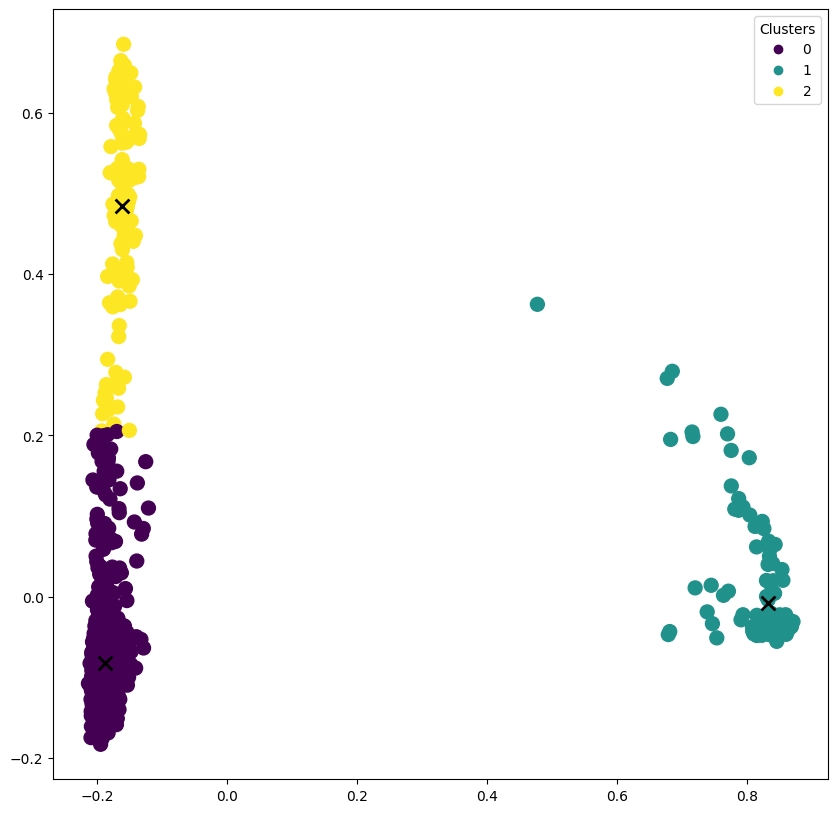

In [ ]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

# Exploration des clusters

### 1er cluster (cluster_0)

In [ ]:
from collections import Counter
from wordcloud import WordCloud
import os
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from IPython.display import Image

[nltk_data] Downloading package stopwords to /home/chloe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Stopwords (Idem que dans s1)
sw = stopwords.words("french")
sw += ["les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout",
       "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous",
       "celle", "entre", "encore", "toutes", "pendant", "moins", "dire", "cela", "non",
       "faut", "trois", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres",
       "van", "het", "autre", "jusqu", "ville", "rossel", "dem", "sach", "heures", "toutes", "hier", "très"
       , "etc", "leurs", "grandes", "lés", "ille", "quo", "peu", "bon", "vers", "grand", "puis", "mois", "personne",
       "devant", "beau", "mén", "elles", "toujours", "déjà", "avenue", "quatre", "fort", "jours", "aujourd",
       "car", "hier", "toute", "grands", "app", "matin", "bne", "bas", "adresser", "haut", "dés",
       "place", "rue", "Bruxelles", "DCM", "ecr", "jour","maison", "ans", "chez", "réf", "prendre",
       "mod", "pers", "suite", "Mme", "voir", "cause", "louer", "porte", "belle", "fille",
       "adr", "quart", "maisons", "rué", "fit", "seule", "agence", "plusieurs", "bonnes", "ceux", "quelques",
       "faits", "jeune", "cent", "vient", "point", "portées", "avant", "serv", "com", "jard",
       "enfant", "désire", "cuis", "Bruxelles", "bruxelles", "grande", "petit", "bons", "dcm", "soir",
       "près", "bonne", "demande", "prix", "fois", "dés", "vendre", "jamais", "chaussée", "bonne", "franc", "lieu", "rien", "quartier",
       "pris", "fois", "tranq", "pos", "vente", "bonne", "neuve", "cuisine", "servante", "mat", "écrire",
       "juillet", "notaire", "dès", "quand", "temps", "pet", "celui", "donné", "partie", "homme", "petite", "cours",
       "mme","part", "coup", "demi", "pens", "neuf", "ruo", "cinq", "ici", "cond", "ferme", "coucher", "demandé",
       "ferm", "comm", "notaires", "août", "prop", "alors", "mardi", "beaucoup", "enfants", "ventes", "lundi", "jeudi",
       "donner", "nuit", "chamb", "chaque", "dimanche", "dos", "uno", "garn", "lés", "fam", "jolie", "demain", "année",
       "petite", "fam", "uno", "celui", "contenant", "premier", "assez", "nouvelles", "beaucoup", "cond", "con",
       "PET", "vendredi", "quand", "nouveau", "gros", "dix", "mieux", "journ", "chaque", "cert", "dém", "dos",
       "vend", "chamb", "alors", "seulement", "mars", "delà", "trop", "courant", "demain", "brux",
       "dernier", "hon", "bel", "seul", "frais", "petits", "dernière", "mis", "diverses", "référ",
       "jne", "tant", "franco", "francs","quelque", "nouvelle", "vieux", "placé", "garni",
       "mal", "sachant", "six", "nommé", "propre", "avril", "coud", "juin", "octobre", "enf",
       "mis", "divers", "sait", "servi", "flam", "septembre", "frais", "hom", "bel", "hon",
       "ouvrir", "enfin", "février", "hui", "dessus", "lès", "janvier", "scs", "partout", "façon",
       "laquelle", "ste", "samedi", "mans", "années", "ment", "mai", "voici", "céder", "surtout",
       "mercredi", "parmi", "franç", "font", "ancien", "cond", "mlle", "jeunes", "beaux", "semaine",
       "garnie", "reçu", "trouve", "derrière", "ruc", "rest", "conn", "lit", "haute", "parce", "fin",
       "aucune", "aussitôt", "ouvr", "aucune", "donne", "certains", "ord", "peuvent", "loin", "décembre",
       "autant", "possible", "première", "prochains", "faite", "voilà", "rendre", "maintenant", "ensuite",
       "los", "novembre", "presque", "ailleurs", "longtemps", "veut", "heure", "cependant", "écrit", "pourrait",
        "comment", "mettre", "abord", "oui", "mêmes", "nombreux", "également", "malgré" ]
sw = set(sw)

In [ ]:
# Ecrire tout le contenu dans un fichier temporaire
temp_path = 'data/tmp/'
if not os.path.exists(temp_path):
    os.mkdir(temp_path)
with open(os.path.join(temp_path, f'cluster_0.txt'), 'w', encoding='utf-8') as f:
    f.write(' '.join(cluster_0))

In [ ]:
def clean_text(folder=None):
    if folder is None:
        input_path = f"cluster_0.txt"
        output_path = f"cluster_0_clean.txt"
    else:
        input_path = f"{folder}cluster_0.txt"
        output_path = f"{folder}/cluster_0_clean.txt"
    output = open(output_path, "w", encoding='utf-8')
    with open(input_path, 'r', encoding='utf-8') as f:
        text = f.read()
        words = nltk.wordpunct_tokenize(text)
        kept = [w.upper() for w in words if len(w) > 2 and w.isalpha() and w.lower() not in sw]
        kept_string = " ".join(kept)
        output.write(kept_string)
    return f'Output has been written in {output_path}!'

In [ ]:
clean_text(folder=temp_path)

'Output has been written in data/tmp//cluster_0_clean.txt!'

In [ ]:
with open(os.path.join(temp_path, f'cluster_0_clean.txt'), 'r', encoding='utf-8') as f:
    after = f.read()

after[:500]

'TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT TXT '

In [ ]:
frequencies = Counter(after.split())
print(frequencies.most_common(10))

[('TXT', 706)]


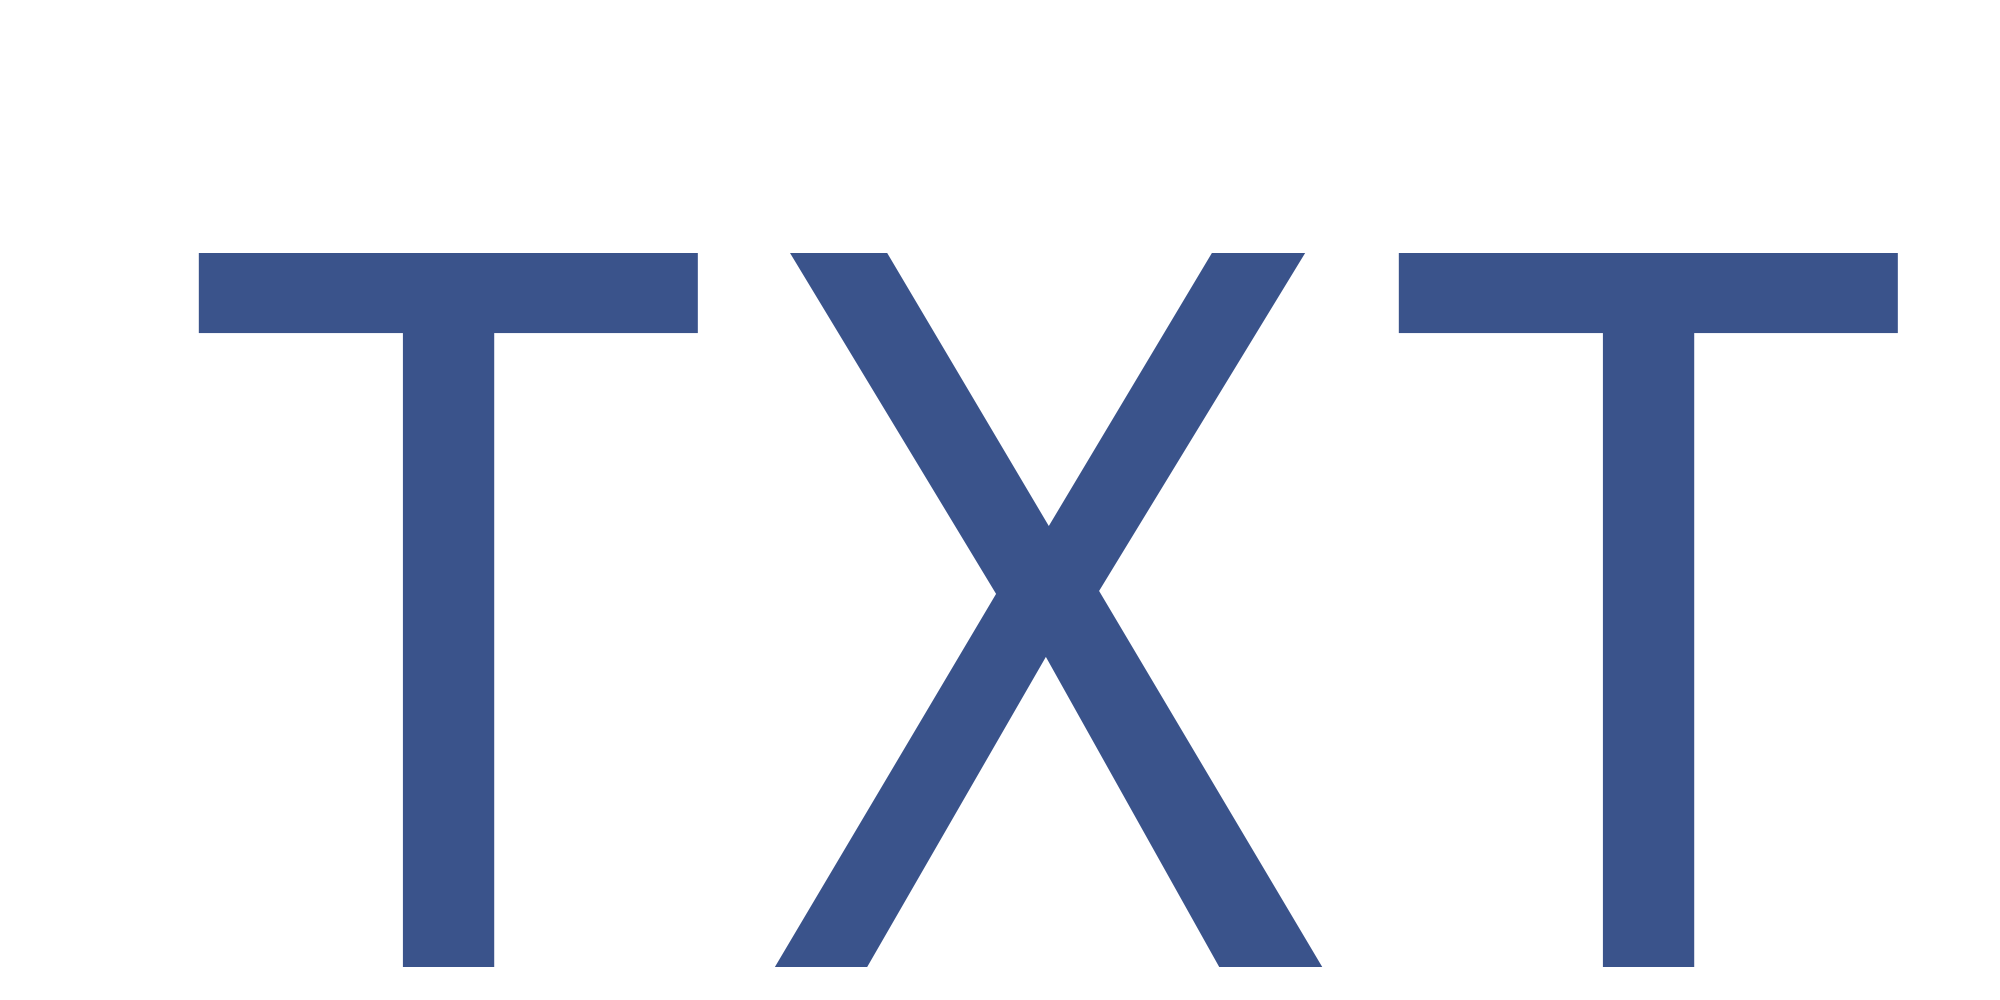

In [ ]:
cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(frequencies)

cloud.to_file(os.path.join(temp_path, f"*.png"))
Image(filename=os.path.join(temp_path, f"*.png"))